In [1]:
import tensorflow as tf
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
# import opendatasets as od
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
import keras

# Load and Process Data

In [2]:
# od.download('https://www.kaggle.com/datasets/gpiosenka/100-bird-species/data')

In [3]:
# Set file path for loading data
train_dir = 'C:/Users/bcbot/COMP_4531/Final/100-bird-species/train'

# List the character files that don't need to be considered
include = ['ALBATROSS', 'ANHINGA', 'ANTBIRD']
categories = []

# Instantiate the containers for holding image and label data
train_data = []

# Load the first 4200 files from each character file in train data
for i in os.listdir(train_dir):
    categories.append(i)
    # if i in include:
    count = 0
    sub_directory = os.path.join(train_dir, i)
    for j in os.listdir(sub_directory):
        count += 1
        if count > 10:
            break
        img = cv2.imread(os.path.join(sub_directory, j))
        train_data.append([img, i])

In [4]:
for x in train_data:
    if x[0].shape != (224, 224, 3):
        x[0] = cv2.resize(x[0], (224, 224))


In [5]:
np.random.seed(7284)
np.random.shuffle(train_data)

In [6]:
lb = LabelBinarizer()

X_train = []
y_train = []
for x, y in train_data:
    X_train.append(x)
    y_train.append(y)

X_train = np.array(X_train)/255
y_train = np.array(y_train)

y_train = lb.fit_transform(y_train)

# Load Model

In [7]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Input, Dense, Flatten
from keras.models import Sequential

In [14]:
model_path = 'C:/Users/bcbot/COMP_4531/Final/100-bird-species/EfficientNetB0-525-(224 X 224)- 98.97.h5'
bmod= keras.models.load_model(model_path, custom_objects={'F1_score':'F1_score'})

In [30]:
bmod.test_on_batch(X_train[:50])

[0.30624327063560486, 0.0]

In [19]:
bmod.evaluate(X_train, y_train)

165/165 [==============================] - 73s 425ms/step - loss: 9.1040 - accuracy: 0.0019


[9.103960990905762, 0.0019047618843615055]

In [23]:
len(bmod.layers)

260

In [35]:
from keras.applications.resnet import ResNet50
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.vgg16 import VGG16

model = Sequential()

model.add(VGG16(weights= 'imagenet', include_top= False, input_shape= (224, 224, 3)))
model.add(Flatten())
model.add(Dense(525))

model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 525)               13171725  
                                                                 
Total params: 27,886,413
Trainable params: 27,886,413
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
model.evaluate(X_train, y_train)

In [ ]:
np.argmax(preds[300])

In [ ]:
train_data[467][1]

In [ ]:
y_hat = []
y_true = []

for x in preds:
    idx = np.argmax(x)
    bird = categories[idx]
    y_hat.append(bird)

for x in y_train:
    idx = np.argmax(x)
    bird = categories[idx]
    y_true.append(bird)

In [ ]:
len(y_true[y_true == y_hat])

Label:  IWI


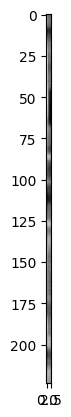

In [66]:
idx = 900
# print('Prediction: ', y_hat[400])
print('Label: ', train_data[idx][1])
plt.gray()
plt.imshow(X_train[idx], cmap='Greys')
plt.show()